Embedding Tests
===

In [148]:
import os
import time
from pathlib import Path

import dotenv
import matplotlib.pyplot as plt
import numpy as np
import openai
import pandas as pd
import scipy
import tiktoken
from tqdm import tqdm

In [4]:
dotenv.load_dotenv("../.env")

True

In [7]:
os.environ["OPENAI_API_KEY"][:3]

'sk-'

In [72]:
openai.api_key = os.environ["OPENAI_API_KEY"]

In [10]:
data_dir = Path("../data")
assert data_dir.exists()
with open(data_dir / "derived" / "rori_lessons.json") as infile:
    df = pd.read_json(infile)
df.shape

(67, 18)

In [96]:
embedding_dir = data_dir / "derived" / "embeddings"
embedding_dir.mkdir(exist_ok=True)

In [13]:
df.iloc[0].lesson_parts, df.iloc[0].short_description

(['Linear expressions are variables that are combined using the signs of addition, subtraction, multiplication and division. \nThey can be added or subtracted by combining the like terms. \n\nLike terms are terms which contain the same variable raised to the same power.\nUnlike terms are terms that have the same variable and are not raised to the same power.\n\nWhen adding polynomials, simply drop the parenthesis and combine like terms. \nWhen subtracting polynomials, distribute the minus sign first, then combine like terms.\n\nLet us check out an example!\n\nWrite *Yes* to continue.',
  'Example:\n\nQues: Simplify the expression below:\n(3x + 4y) - (2x + 5y)\nA. x - y\nB. 5x - y\nC. 2x- y\nD. x - y\n\nHint: \nDistribute the negative sign to 2x + 5y.\n3x + 4y - 2x - 5y\n= (3x - 2x) + (4y - 5y)\n= x - y\n\nAns: A\n\nWould you like to try some questions?\n\nWrite *Yes* to continue.'],
 'Let us learn how to add and subtract linear expressions with 2 or more variables.')

In [45]:
ds = []
ada_tokeniser = tiktoken.encoding_for_model("text-embedding-ada-002")
for row in df.itertuples():
    lesson_code = row.lesson_code
    db_string = row.short_description + "\n\n" + "\n\n".join(row.lesson_parts)
    db_string_token_count = len(ada_tokeniser.encode(db_string))
    ds.append(
        {
            "lesson_code": lesson_code,
            "grade": row.grade,
            "db_string": db_string,
            "db_string_token_count": db_string_token_count,
        }
    )
embed_df = pd.DataFrame(ds)

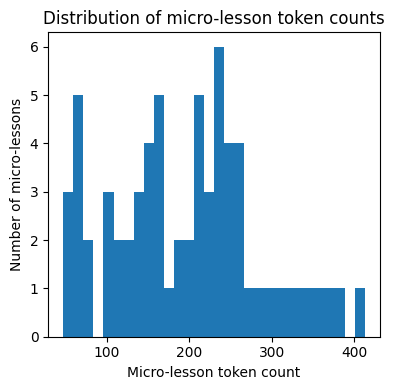

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.hist(embed_df.db_string_token_count, bins=30)
ax.set_title("Distribution of micro-lesson token counts")
ax.set_xlabel("Micro-lesson token count")
ax.set_ylabel("Number of micro-lessons")

fig.tight_layout()
plt.show()

In [42]:
embed_df.sort_values(by="db_string_token_count").head(10)

,lesson_code,db_string,db_string_token_count
28,G6.N1.3.3.5,In today's lesson we are going to solve word p...,47
49,G6.N3.1.1.4,Even decimal numbers have place values . Let u...,54
27,G6.N1.3.3.4,Let us multiply a 3 and 4 digit number with re...,55
26,G6.N1.3.3.3,In today's lesson let us learn to multiply a 3...,65
31,G6.N1.3.3.13,In today's lesson we are going to try out word...,65
29,G6.N1.3.3.8,In today's lesson we are going to learn and pr...,66
57,G7.N3.3.2.2,"Today, we are going to learn how to divide a d...",70
30,G6.N1.3.3.9,In today's lesson we are going to practice per...,71
46,G6.N2.2.3.10,Can you find the reciprocal of a fraction? Tur...,82
15,G6.N1.1.1.1,"Today we will read and write numbers upto 1,00...",83


In [50]:
# let's investigate the relationship between grade and token count
grades = []
data = []
for grade, group in embed_df.groupby("grade"):
    list = group.db_string_token_count.tolist()
    grades.append(grade)
    data.append(list)

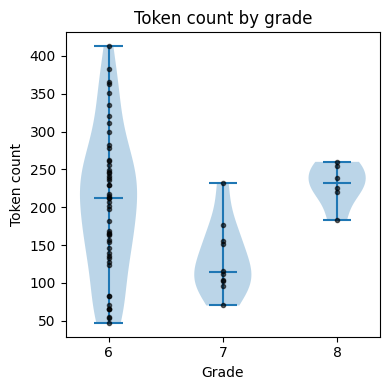

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.violinplot(data, showmedians=True)
for x, values in zip([1, 2, 3], data):
    ax.scatter(
        [
            x,
        ]
        * len(values),
        values,
        color="black",
        marker=".",
        zorder=20,
        alpha=0.6,
    )
ax.set_title("Token count by grade")
ax.set_xlabel("Grade")
ax.set_ylabel("Token count")
ax.set_xticks([1, 2, 3], labels=grades)

fig.tight_layout()
plt.show()

In [75]:
embedding_model = "text-embedding-ada-002"

# remove new-lines to improve performance, according to OpenAI
texts = [row.db_string.replace("\n", " ") for row in embed_df.itertuples()]

result = openai.Embedding.create(input=texts, engine=embedding_model)

In [78]:
result.usage

<OpenAIObject at 0x28c290a40> JSON: {
  "prompt_tokens": 13323,
  "total_tokens": 13323
}

In [85]:
embeddings = [np.array(d["embedding"]) for d in result.data]
assert all([e.shape == (1536,) for e in embeddings])
len(embeddings)

67

In [98]:
db = np.concatenate([e.reshape(1, -1) for e in embeddings], axis=0)
db.shape

(67, 1536)

In [100]:
embed_df.to_parquet(embedding_dir / "rori_embed_df.parquet")
np.save(embedding_dir / "rori_embed_db.npy", db)

### Embed questions to use as queries

In [104]:
ds = []
for row in df.itertuples():
    for question in row.questions:
        text = question["question"] + "\n\n" + question["hint"]
        ds.append(
            {
                "target_lesson_code": row.lesson_code,
                "target_domain": row.domain,
                "target_grade": row.grade,
                "target_construct": row.construct,
                "target_subconstruct": row.subconstruct,
                "query": text,
            }
        )
query_df = pd.DataFrame(ds)
query_df.shape

(664, 6)

In [106]:
embedding_model = "text-embedding-ada-002"
texts = [row.query.replace("\n", " ") for row in query_df.itertuples()]
result = openai.Embedding.create(input=texts, engine=embedding_model)

In [107]:
embeddings = [np.array(d["embedding"]) for d in result.data]
query_db = np.concatenate([e.reshape(1, -1) for e in embeddings], axis=0)
query_db.shape

(664, 1536)

In [108]:
query_df.to_parquet(embedding_dir / "rori_query_df.parquet")
np.save(embedding_dir / "rori_query_db.npy", query_db)

### Code for eval

In [143]:
def get_gpd_codes(lesson_code):
    """
    Structure is: G<grade>.<domain><construct>.<subconstruct>.<skill>.<index>

    e.g. G9.N5.1.3.1 has:
        grade 9
        domain N
        construct N5
        subconstruct N5.1
        skill N5.1.3
        index 1
    """
    tokens = lesson_code.split(".")
    grade = int(tokens[0][1])
    index = int(tokens[-1])

    skill = ".".join(tokens[1:-1])

    domain = tokens[1][0]
    construct = tokens[1]
    subconstruct = tokens[1] + "." + tokens[2]
    return grade, domain, construct, subconstruct, skill, index


get_gpd_codes("G9.N5.1.3.1"), get_gpd_codes("G9.N0.0.0.1")

((9, 'N', 'N5', 'N5.1', 'N5.1.3', 1), (9, 'N', 'N0', 'N0.0', 'N0.0.0', 1))

### Load and query the embedding DB

In [114]:
embed_df = pd.read_parquet(embedding_dir / "rori_embed_df.parquet")
db = np.load(embedding_dir / "rori_embed_db.npy")
embed_df.shape, db.shape

((67, 4), (67, 1536))

In [115]:
query_df = pd.read_parquet(embedding_dir / "rori_query_df.parquet")
query_db = np.load(embedding_dir / "rori_query_db.npy")
query_df.shape, query_db.shape

((664, 6), (664, 1536))

In [125]:
def query_embedding_db(query_embedding, db, db_df):
    return False


query_embedding = query_db[0, :].reshape(1, -1)

distances = scipy.spatial.distance.cdist(query_embedding, db, metric="cosine")[0]

In [126]:
scipy.stats.rankdata(distances, method="max")

array([ 1,  4, 61, 35, 51, 34, 32, 28, 57, 66, 63, 30, 65, 50, 67, 53, 62,
       64, 54, 49, 26, 21, 36, 17, 42, 44, 24, 16, 25, 33, 40, 31,  3, 29,
       19, 43, 12, 59, 15, 23, 46,  7, 11,  6,  8, 27, 38, 18, 10, 56, 58,
       48, 45, 60, 13, 20, 55, 41, 37,  9,  5, 14, 22,  2, 52, 39, 47])

In [130]:
sort_inds = np.argsort(distances)
sort_inds

array([ 0, 63, 32,  1, 60, 43, 41, 44, 59, 48, 42, 36, 54, 61, 38, 27, 23,
       47, 34, 55, 21, 62, 39, 26, 28, 20, 45,  7, 33, 11, 31,  6, 29,  5,
        3, 22, 58, 46, 65, 30, 57, 24, 35, 25, 52, 40, 66, 51, 19, 13,  4,
       64, 15, 18, 56, 49,  8, 50, 37, 53,  2, 16, 10, 17, 12,  9, 14])

In [135]:
smallest_distances = distances[sort_inds[:3]]
smallest_distances

array([0.15034087, 0.17756433, 0.18582566])

In [136]:
embed_df.lesson_code.iloc[sort_inds[:3]]

0     G8.A2.1.2.1
63    G7.N4.2.2.1
32    G6.N1.3.7.1
Name: lesson_code, dtype: object

In [141]:
lesson_code_index_map = {v: k for k, v in embed_df.lesson_code.to_dict().items()}
target_index = lesson_code_index_map[query_df.iloc[0].target_lesson_code]
target_index

0

In [166]:
assert len(query_db) == len(query_df)
rs = []
for query_ind in tqdm(range(len(query_df))):
    query_embedding = query_db[query_ind, :].reshape(1, -1)
    query_row = query_df.iloc[query_ind]
    target_lesson_code = query_row.target_lesson_code
    target_index = lesson_code_index_map[target_lesson_code]

    distances = scipy.spatial.distance.cdist(query_embedding, db, metric="cosine")[0]
    sort_inds = np.argsort(distances)
    ranks = scipy.stats.rankdata(distances, method="max")

    target_rank = ranks[target_index]
    r = {
        "query_ind": query_ind,
        "target_lesson_code": target_lesson_code,
        "target_index": target_index,
        "target_rank": target_rank,
    }
    rs.append(r)
eval_df = pd.DataFrame(rs)
eval_df["reciprocal_rank"] = 1 / eval_df.target_rank
eval_df.shape

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 664/664 [00:00<00:00, 3799.24it/s]


(664, 5)

In [167]:
eval_df.reciprocal_rank.mean()

0.6632352554320463

In [168]:
eval_df.groupby("target_lesson_code").mean()

,query_ind,target_index,target_rank,reciprocal_rank
target_lesson_code,,,,
G6.A1.1.2.1,84.5,8.0,3.5,0.370833
G6.A1.1.3.1,74.5,7.0,5.8,0.625776
G6.A1.1.4.1,64.5,6.0,8.7,0.387288
G6.A3.1.1.1,54.5,5.0,1.6,0.766667
G6.G1.1.3.1,114.5,11.0,1.0,1.000000
...,...,...,...,...
G8.A2.1.2.1,4.5,0.0,2.0,0.650000
G8.N3.2.4.1,24.5,2.0,2.4,0.466667
G8.N3.2.4.2,638.5,64.0,1.9,0.797619


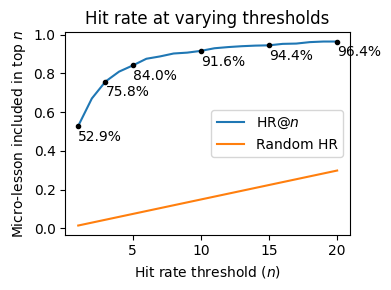

In [183]:
xs = []
ys = []
for n in range(1, 21):
    hr = (eval_df.target_rank <= n).sum() / len(eval_df)
    xs.append(n)
    ys.append(hr)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))

ax.plot(xs, ys, label="HR@$n$")

random_ys = [x / len(embed_df) for x in xs]
ax.plot(xs, random_ys, label="Random HR")

for n in [1, 3, 5, 10, 15, 20]:
    ax.scatter(n, ys[n - 1], color="black", zorder=10, marker=".")
    ax.text(n, ys[n - 1] - 0.02, f"{ys[n-1]:.1%}", va="top", ha="left")

ax.set_title("Hit rate at varying thresholds")
ax.set_xlabel("Hit rate threshold ($n$)")
ax.set_ylabel("Micro-lesson included in top $n$")

ax.legend()

fig.tight_layout()
plt.show()